In [1]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [3]:
# Model setup
L = 1  # Thickness of the plate
N = 50  # mesh density
mesh = UnitSquareMesh(N,N)

# Get the number of elements
num_elements = mesh.num_cells()
print("Number of elements:", num_elements)

n = FacetNormal(mesh)

Number of elements: 5000


In [4]:
# Define boundary conditions
class Left(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[0], 0)
class Right(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[0], L)
class Top(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[1], L)
class Bottom(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[1], 0)

# Add boundaries
left = Left()
right = Right()
top = Top()
bottom = Bottom()

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
top.mark(boundaries,3)
bottom.mark(boundaries,4)

In [5]:
### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_µ = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
V = FunctionSpace(mesh, MixedElement([element_u, element_µ]))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [6]:
# Parameters Normalised
µ_init = -0.3124 # initial chemical potential
A = 4000
lmbda = 1558
alpha = 0.66 # robin bcs

In [7]:
# zero displacement boundary conditions on the symmetric part of the plate
u_bc_bottom = DirichletBC(V.sub(0).sub(1), Constant(0.0), bottom) 
u_bc_left = DirichletBC(V.sub(0).sub(0), Constant(0.0), left)

µ_swell = -0.001

bcs = [u_bc_bottom, u_bc_left] 

In [8]:
# Class representing the intial conditions
class InitialConditions(UserExpression):
    def eval(self, values, x):
        values[0] = 0.0                 # ux
        values[1] = 0.0                 # uy
        values[2] = µ_init #-0.3124        # mu
    def value_shape(self):
        return (3,)

In [9]:
dU = TrialFunction(V)
(du, dµ) = split(dU)
V_ = TestFunction(V)
(v, q) = split(V_)
Uold = Function(V)
(uold, µold) = split(Uold)
U = Function(V)
(u, µ) = split(U)

# Create intial conditions and interpolate
u_init = InitialConditions()
Uold.interpolate(u_init)

In [10]:
# Strain
def eps(u):
    return sym( grad(u) )
# Stress 
def sigma(u, µ):
    return 2*eps(u) + ( lmbda*tr(eps(u)) - A*(µ-µ_init) )*Identity(mesh.topology().dim())

In [11]:
dt = Constant(0.)
ds = Measure('ds', subdomain_data=boundaries)

mech_form = inner( sigma(du, dµ),eps(v))*dx
chem_form = ( tr( eps(du)-eps(uold) )/dt )*q*dx + dot(grad(dµ),grad(q))*dx +  Constant(alpha)*(dµ-µ_swell)*q*ds(2) + Constant(alpha)*(dµ-µ_swell)*q*ds(3)
form = mech_form + chem_form

In [12]:
import os

# Define the directory to save the figures
save_dir = "results/FOM/time/"  # Replace with your desired path

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Nincr = 100
t = np.linspace(0, 0.25, Nincr+1)
# t = np.linspace(0, 1.0, Nincr+1)
Nx = 100
x = np.linspace(0, L, Nx)
Sigyy = np.zeros((Nincr+1, ))
Epsyy = np.zeros((Nincr+1, ))
µ_res = np.zeros((Nincr+1, ))
res = np.zeros((Nx, Nincr+1))

# this is used to store u at each time step
S = FunctionSpace(mesh, element_µ)
u_time = []
ux_time = []
uy_time = []
sigma_xx_array_L = np.zeros((Nincr+1, ))
sigma_xx_array_0 = np.zeros((Nincr+1, ))
sigma_xx_array_0L = np.zeros((Nincr+1, ))

µ_time = []

# Define fixed color scale range
import matplotlib.colors as mcolors
vmin = 0.0
vmax = 0.08
cbar_ticks = np.linspace(vmin, vmax, num=5)
# Create a Normalize object for the color scale
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    t_current = t[i+1]
    dt.assign(dti)
    solve(lhs(form) == rhs(form), U, bcs)
    Uold.assign(U)
    (u, µ) = split(U)
    res[:, i+1] = [U(xi, 0.0)[2] for xi in x]
    # get average stress/strain
    Sigyy[i+1] = assemble(sigma(u, µ)[1, 1]*dx)
    #episoln = eps(u)(0,0)[1, 1]
    Epsyy[i+1] = assemble(eps(u)[1, 1]*dx)
    µ_res[i+1] = assemble(µ*dx)
    
    # u is stored at each time step
    u_time.append(u)
    ux_time.append(project(u[0], S))
    uy_time.append(project(u[1], S))
    
    sigma_xx = sigma(u,μ)[0,0]
    sigma_xx_P1 = project(sigma_xx, S)
    sigma_xx_array_L[i+1] = sigma_xx_P1(L, L)
    sigma_xx_array_0[i+1] = sigma_xx_P1(0, 0)
    sigma_xx_array_0L[i+1] = sigma_xx_P1(0, L)
    
    µ_time.append(project(µ,S))

    # Plot every N iterations
    if i == 1 or i == 50 or i == 99: #(i+1) % 20 == 0:
        # Plotting with a fixed color scale
        plt.figure(figsize=(6,5))
        p = plot(µ, title="$\mu$ at time {}".format(i+1))
        plt.xlim((0, L))
        plt.ylim((0, L))
        
        if i == 99:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both')
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\mu/k_B T$ ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"chemPotential_{i+1}.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.close()
        
        # Plotting with a fixed color scale
        plt.figure(figsize=(6,5))
        displacement_magnitude = sqrt(inner(u,u))
        p = plot(displacement_magnitude, title="$u$ at time {}".format(i+1), 
                vmin=vmin, vmax=vmax)
        plt.xlim((0, L))
        plt.ylim((0, L))
        
        if i == 99:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both')
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\vert\vert u \vert\vert^2$ ($T = {:.2f}$)".format(t_current), fontsize = 16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"dispField_{i+1}.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.close()
        
        # Plotting strain
        plt.figure(figsize=(6,5))
        p = plot(eps(u)[0,0], title="$\epsilon$ at {}".format(i+1), 
                vmin=vmin, vmax=0.15)
        plt.xlim((0, L))
        plt.ylim((0, L))
        
        if i == 99:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both', format="%.3f")
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\varepsilon_{{XX}}$ ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"strain_XX_{i+1}.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.close()        
        
        # Plotting stress
        plt.figure(figsize=(6,5))
        p = plot(sigma(u,μ)[0,0], title="$\sigma$ at {}".format(i+1))#, 
                # vmin=vmin, vmax=0.11)
        plt.xlim((0, L))
        plt.ylim((0, L))
        
        if i == 99:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both', format="%.3f")
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\sigma_{{XX}}/G$ ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"stress_XX_{i+1}.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.close()

Increment 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JI

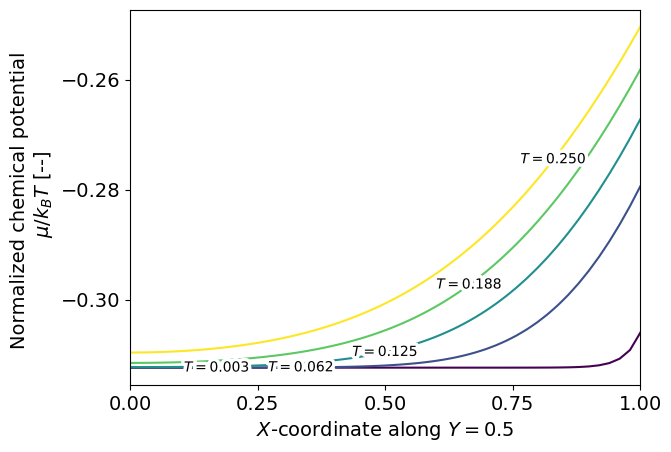

In [13]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator

# Setup figure and axis
fig, ax = plt.subplots(figsize=(6,5))

# Define the range of values for normalization
# nValues = np.arange(1, Nincr, Nincr // 5)
nValues = np.array([1, 25, 50, 75, 100])

# Setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

# Plotting using a loop
for n in nValues:
    ax.plot(x, res[:, n], color=colormap(normalize(n)), label="$T = {:.3f}$".format(t[n]))

# Label lines
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)

# Set labels and other properties
ax.set_xlabel("$X$-coordinate along $Y=0.5$", fontsize=14)
ax.set_ylabel("Normalized chemical potential \n $\mu/k_B T$ [--]", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlim((0, L))

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))  # Adjust number of bins as needed
ax.yaxis.set_major_locator(MaxNLocator(nbins=4))  # Adjust number of bins as needed

# Adjust layout
plt.tight_layout()  # Adjust the layout
# Adjust the margins
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)

plt.savefig('results/FOM/Fig_2DFEM_mu_time.pdf', bbox_inches='tight')

plt.show()

/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=0.8). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=1.8). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 2 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=2.8). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 3 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=3.8). Clipping it into the 

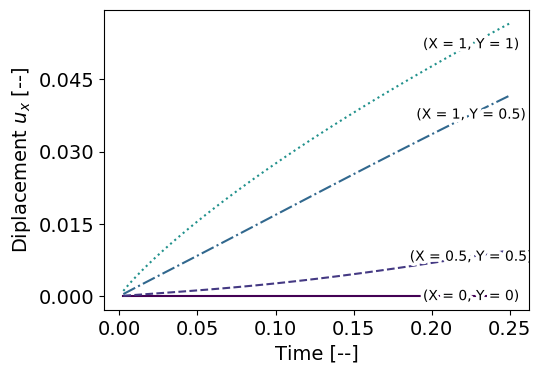

In [14]:
# Assuming ux_time, t, Nincr are already defined
# Initialize arrays to store displacement values for each point
ux_00 = np.zeros(Nincr)
ux_05 = np.zeros(Nincr)
ux_11 = np.zeros(Nincr)
ux_15 = np.zeros(Nincr)

# Extract displacement values for each point at each time step
for i in range(Nincr):
    ux_00[i] = ux_time[i](0, 0)
    ux_05[i] = ux_time[i](0.5, 0.5)
    ux_11[i] = ux_time[i](1, 1)
    ux_15[i] = ux_time[i](1, 0.5)

# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization
nPoints = 4
points = np.arange(nPoints)

# Setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max()*2)
colormap = cm.viridis

# Define different line styles for each plot
line_styles = ['-', '--', '-.', ':']

# Plotting using a loop
ax.plot(t[1:], ux_00, line_styles[0], color=colormap(normalize(points[0])), label='(X = 0, Y = 0)')
ax.plot(t[1:], ux_05, line_styles[1], color=colormap(normalize(points[1])), label='(X = 0.5, Y = 0.5)')
ax.plot(t[1:], ux_15, line_styles[2], color=colormap(normalize(points[2])), label='(X = 1, Y = 0.5)')
ax.plot(t[1:], ux_11, line_styles[3], color=colormap(normalize(points[3])), label='(X = 1, Y = 1)')

# # Label lines
# labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)

x_positions_for_labels = [0.8 + i for i in range(len(ax.get_lines()))]

# Use labelLines with the xvals parameter, providing a list of x positions
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10, xvals=x_positions_for_labels)

# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel('Diplacement $u_x$ [--]', fontsize=14)
# ax.set_title('Displacement over Time for Different Points in the Domain', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust number of bins as needed
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust number of bins as needed

# Adjust layout
plt.tight_layout()  # Adjust the layout
# Adjust the margins
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)

plt.savefig('results/FOM/Fig_2DFEM_disp_time.pdf', bbox_inches='tight')

plt.show()

/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=0.8). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=1.8). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 2 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=2.8). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 3 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=3.8). Clipping it into the 

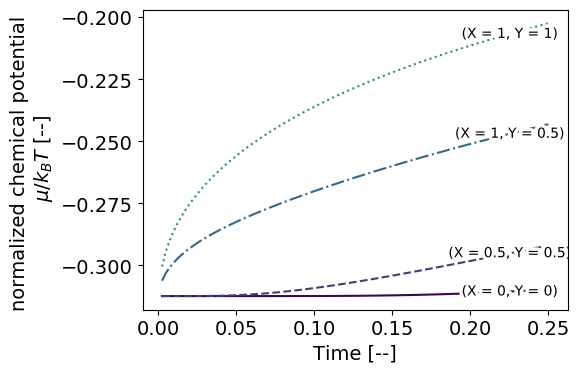

In [15]:
# Assuming µ_time, t, Nincr are already defined
# Initialize arrays to store µ values for each point
µ_00 = np.zeros(Nincr)
µ_05 = np.zeros(Nincr)
µ_11 = np.zeros(Nincr)
µ_15 = np.zeros(Nincr)

# Extract displacement values for each point at each time step
for i in range(Nincr):
    µ_00[i] = µ_time[i](0, 0)
    µ_05[i] = µ_time[i](0.5, 0.5)
    µ_11[i] = µ_time[i](1, 1)
    µ_15[i] = µ_time[i](1, 0.5)

# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization
nPoints = 4
points = np.arange(nPoints)

# Setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max()*2)
colormap = cm.viridis

# Define different line styles for each plot
line_styles = ['-', '--', '-.', ':']

# Plotting using a loop
ax.plot(t[1:], µ_00, line_styles[0], color=colormap(normalize(points[0])), label='(X = 0, Y = 0)')
ax.plot(t[1:], µ_05, line_styles[1], color=colormap(normalize(points[1])), label='(X = 0.5, Y = 0.5)')
ax.plot(t[1:], µ_15, line_styles[2], color=colormap(normalize(points[2])), label='(X = 1, Y = 0.5)')
ax.plot(t[1:], µ_11, line_styles[3], color=colormap(normalize(points[3])), label='(X = 1, Y = 1)')

# # Label lines
# labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)

x_positions_for_labels = [0.8 + i for i in range(len(ax.get_lines()))]

# Use labelLines with the xvals parameter, providing a list of x positions
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10, xvals=x_positions_for_labels)


# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel('normalized chemical potential \n $\mu/k_B T$ [--]', fontsize=14)
# ax.set_title('Displacement over Time for Different Points in the Domain', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust number of bins as needed
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust number of bins as needed

# Adjust layout
plt.tight_layout()  # Adjust the layout
# Adjust the margins
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)

plt.savefig('results/FOM/Fig_2DFEM_mu_time.pdf', bbox_inches='tight')

plt.show()

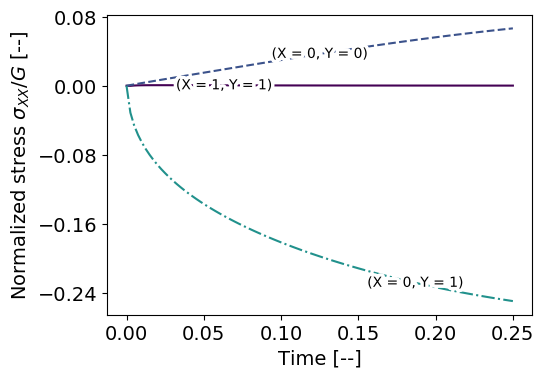

In [16]:
# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization
nPoints = 3
points = np.arange(nPoints)

# Setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max()*2)
colormap = cm.viridis

# Define different line styles for each plot
line_styles = ['-', '--', '-.', ':']

# Plotting using a loop
ax.plot(t, sigma_xx_array_L, line_styles[0], color=colormap(normalize(points[0])), label='(X = 1, Y = 1)')
ax.plot(t, sigma_xx_array_0, line_styles[1], color=colormap(normalize(points[1])), label='(X = 0, Y = 0)')
ax.plot(t, sigma_xx_array_0L, line_styles[2], color=colormap(normalize(points[2])), label='(X = 0, Y = 1)')

# Label lines
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)

# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel("Normalized stress $\sigma_{{XX}}/G$ [--]", fontsize=14)
# ax.set_title('Displacement over Time for Different Points in the Domain', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust number of bins as needed
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust number of bins as needed

# Adjust layout
plt.tight_layout()  # Adjust the layout
# Adjust the margins
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)

plt.savefig('results/FOM/Fig_2DFEM_stress_time.pdf', bbox_inches='tight')

plt.show()